In [345]:
import pandas as pd
from datetime import datetime
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import glob as glob
import matplotlib.dates as mdates
import seaborn as sns

In [346]:
def simple_read(path):
    # path to data -> pandas DataFrame with time columns converted to date time
    with open(path) as f:
        # find the value in the file which tells you how many lines to skip to get to the table
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
    data = pd.read_csv(path, sep=',', skiprows=header_line)

    # finds the location in the path containing the date
    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
        
    # creates datetime object with the date the data was collected
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8])) 
    
    for column in data.keys():
        if 'Time' in column:
            # converts seconds after midnight columns to datetime
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    data.columns = data.columns.str.replace(' ', '')
    return data.replace(-9999, np.NaN) # Converts -9999 values to NaN

In [347]:
d_path = sorted(glob.glob('./ict_data/ARCSIX-DASH*'))

In [348]:
dash=[]
for i in range(0,len(d_path)):
    dash.append(simple_read(d_path[i]))

In [349]:
mn_path = sorted(glob.glob('./ict_data/ARCSIX-MetNav*'))

In [350]:
met_nav=[]
for i in range(0,len(mn_path)):
    met_nav.append(simple_read(mn_path[i]))

In [351]:
d_m = []
for i in range(0,len(met_nav)):
    d_m.append(pd.merge_asof(met_nav[i], dash[i], left_on='Time_Start', right_on='Time_Mid', direction = 'nearest', tolerance=timedelta(seconds=1)))

In [352]:
def plotter(d_m, key, min, max):
    
    # Create a figure and a set of subplots with a polar projection
    fig, axs = plt.subplots(2, 2, figsize=(10, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})

    for i, ax in enumerate(axs.ravel()):
        # Example data: latitudes, longitudes, and a third variable (e.g., temperature)
        lats = d_m[i]['Latitude']#[60, 61, 62, 63, 64, 65]
        lons = d_m[i]['Longitude']#[-45, -44, -43, -42, -41, -40]
        third_variable = d_m[i][key].interpolate(limit=500)#[10, 15, 20, 25, 30, 35]  # Example third variable (e.g., temperature)


        # Add coastlines and gridlines
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines()

        # Set the extent of the map to focus on Greenland
        ax.set_extent([-75, -60, 75, 90], crs=ccrs.PlateCarree())
        cmap.set_bad('gray')
        # Create segments for the line plot
        points = np.array([lons, lats]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        norm = plt.Normalize(min, max)
        lc = LineCollection(segments, cmap='spring', norm=norm, linewidth=6, transform=ccrs.PlateCarree())

        # Set the color values for the line segments
        lc.set_array(np.array(third_variable))
        ax.plot(lons, lats, transform=ccrs.PlateCarree(), lw=6, c='black', alpha=.5)
        # Add the LineCollection to the plot
        ax.add_collection(lc)
        # Add a title
        ax.set_title(titles[i])
        # Add a colorbar
        #cbar = plt.colorbar(lc, orientation='vertical', pad=0.05)
        #cbar.set_label('Third Variable (e.g., Temperature)')
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(lc, cax=cbar_ax, orientation='vertical')
    cbar.set_label(key)

  

    # Show the plot
    plt.savefig('./figures/map_plot-'+key+'.png', dpi=300)
    plt.show()

In [353]:
titles=['RF 1', 'RF 2', 'RF 3', 'RF 4', 'RF 5', 'RF 6']

In [354]:
for i in range(0,len(d_m)):
    print(d_m[i]['RI'].min(),d_m[i]['RI'].max())

1.35 1.54
1.39 1.53
1.37 1.54
1.39 1.55


In [355]:
for i in range(0,len(d_m)):
    print(d_m[i]['GF'].min(),d_m[i]['GF'].max())

0.31 4.8
0.67 6.32
0.65 3.93
0.87 7.93


KeyboardInterrupt: 

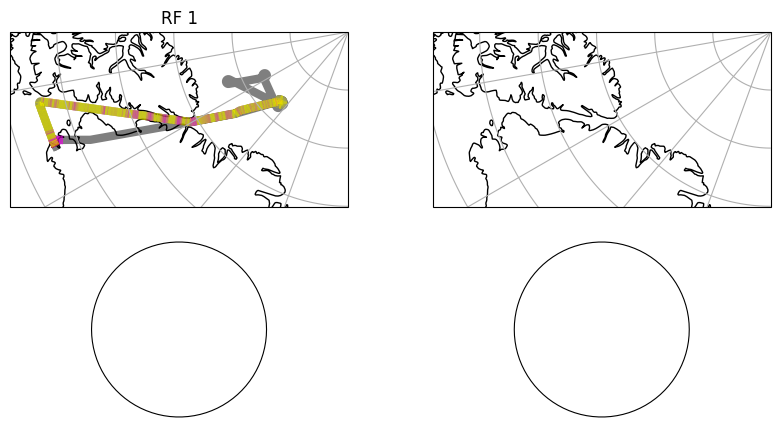

In [356]:
plotter(d_m, 'RI', 1.4, 1.5)

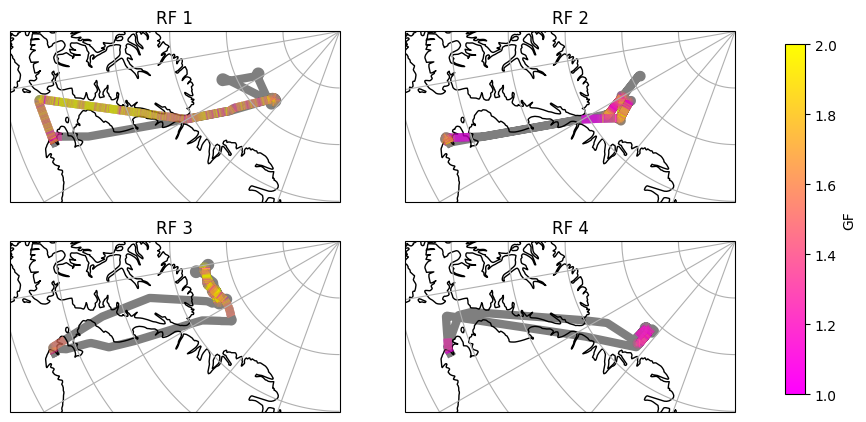

In [ ]:
plotter(d_m, 'GF', 1, 2)

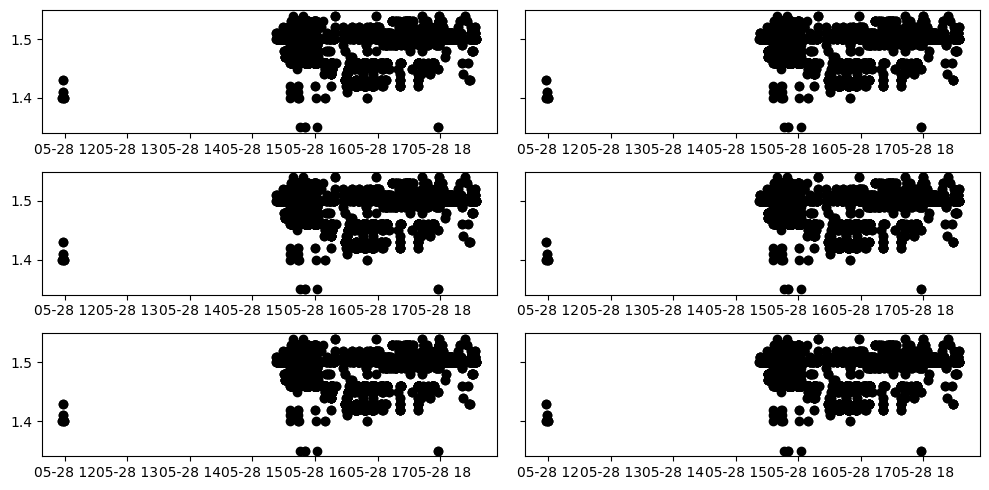

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 5), sharey=True)
for i,ax in enumerate(axs.ravel()):
    d = d_m[0]

    d = d[np.isfinite(d['Time_Mid'])]
    # Identify the indices where the time difference is greater than 5 minutes
    gap_indices = d.index[d['Time_Mid'].diff() > timedelta(seconds=5)].tolist()
    
    old_i = 0
    for i in gap_indices:
        ax.scatter(d.loc[old_i:i-1,'Time_Start_y'], d.loc[old_i:i-1,'RI'], c='black')
        old_i = i
fig.tight_layout()

In [368]:
def line_alt(d_m, key, min, max):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

    for i, ax in enumerate(axs.ravel()):
        d = d_m[i]

        # Fill NaN values in 'RI' with a placeholder for colormap
        #d['RI_filled'] = d['RI'].fillna(-1)
        norm = plt.Normalize(min,max)
        cmap = sns.color_palette("spring", as_cmap=True)
        #cmap.set_bad('gray')

        # Create segments for the line plot
        points = np.array([mdates.date2num(d['Time_Start_x']), d['GPS_Altitude']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=2)
        lc.set_array(d['GF'].interpolate(limit=500))

        # Add the LineCollection to the plot
        ax.plot(d['Time_Start_x'], d['GPS_Altitude'], lw=2, c='black', alpha=.5)
        ax.add_collection(lc)
        ax.autoscale()

        # Format x-axis
        ax.set_title(titles[i])
        date_format = mdates.DateFormatter('%H')
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        if i in [2,3]:
            ax.set_xlabel('Hour [UTC]')
        if i in [0,2]:
            ax.set_ylabel('GPS Altitude')

    # Add a master colorbar
    fig.tight_layout()
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(lc, cax=cbar_ax)
    cbar.set_label(key)
    
    fig.savefig('./figures/alt_time-'+key+'.png', dpi=300)
    plt.show()

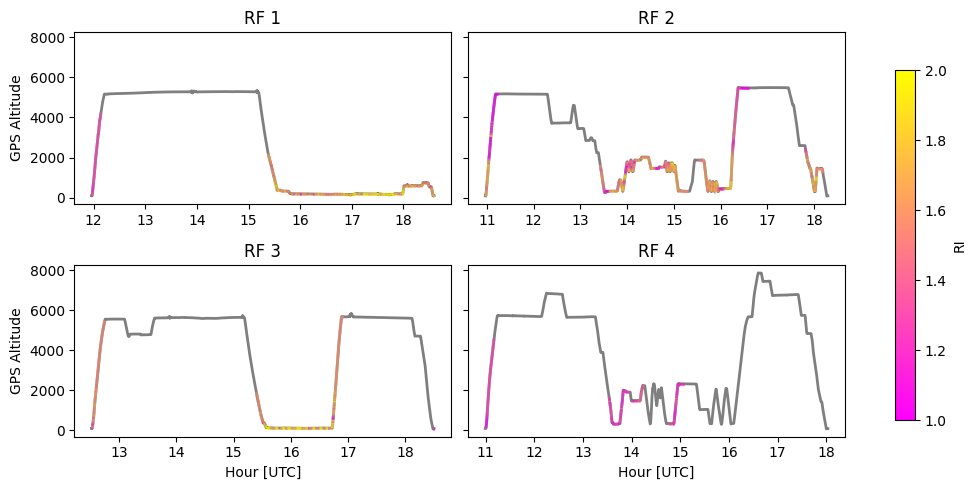

In [369]:
line_alt(d_m, 'RI', 1,2)

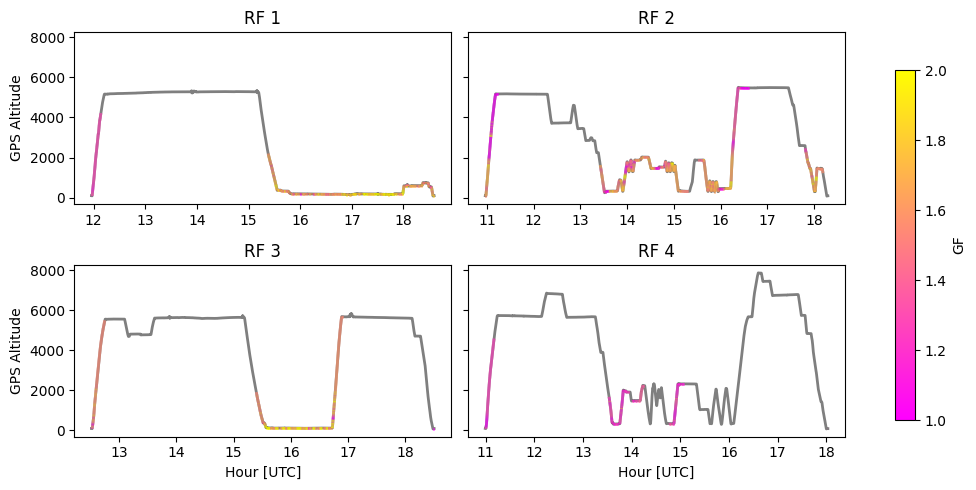

In [370]:
line_alt(d_m, 'GF', 1,2)

In [276]:
d_m[0].keys()

Index(['Time_Start_x', 'Day_Of_Year', 'Latitude', 'Longitude', 'GPS_Altitude',
       'Pressure_Altitude', 'Radar_Altitude', 'Ground_Speed', 'True_Air_Speed',
       'Indicated_Air_Speed', 'Mach_Number', 'Vertical_Speed', 'True_Heading',
       'Track_Angle', 'Drift_Angle', 'Pitch_Angle', 'Roll_Angle',
       'Static_Air_Temp', 'Potential_Temp', 'Dew/Frost_Point',
       'Total_Air_Temp', 'IR_Surf_Temp', 'Static_Pressure', 'Cabin_Pressure',
       'Wind_Speed', 'Wind_Direction', 'U', 'V', 'Solar_Zenith_Angle',
       'Aircraft_Sun_Elevation', 'Sun_Azimuth', 'Aircraft_Sun_Azimuth',
       'Mixing_Ratio', 'Part_Press_Water_Vapor', 'Sat_Vapor_Press_H2O',
       'Sat_Vapor_Press_Ice', 'Relative_Humidity', 'Time_Start_y', 'Time_Stop',
       'Time_Mid', 'RH', 'Dp', 'RI', 'GF'],
      dtype='object')